In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS =3
EPOCHS = 30

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/new_ds",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2900 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 0 0 2 2 2 0 2 1 1 0 1 2 0 0 0 0 1 2 2 0 1 2 1 2 1 0 2 2 0 0 2]


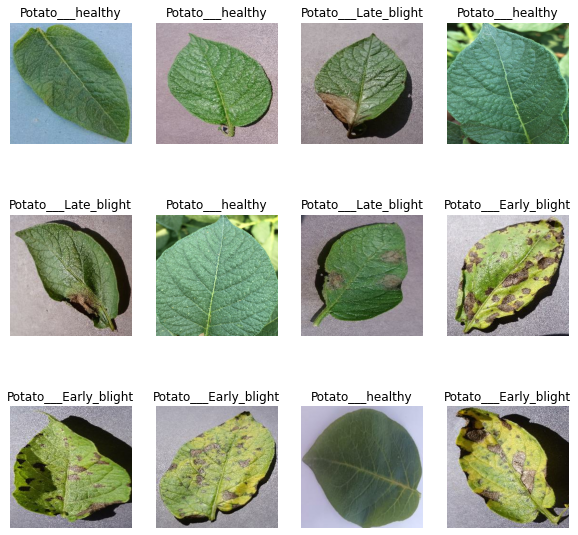

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,1+i)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  assert  (train_split + test_split + val_split) == 1

  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  val_size = int(val_split * ds_size)
    
  train_ds = ds.take(train_size)    
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
    
  return train_ds, val_ds, test_ds


In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
(len(train_ds) , len(val_ds), len(test_ds))

(72, 9, 10)

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [13]:
data_augmentation = tf.keras.Sequential([
 layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
 layers.experimental.preprocessing.RandomRotation(0.2),
])

In [14]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [16]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [18]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [19]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/30
72/72 [==============================] - 260s 348ms/step - loss: 0.8155 - accuracy: 0.6213 - val_loss: 0.9266 - val_accuracy: 0.6632
Epoch 2/30
72/72 [==============================] - 17s 241ms/step - loss: 0.4732 - accuracy: 0.8072 - val_loss: 0.3293 - val_accuracy: 0.8611
Epoch 3/30
72/72 [==============================] - 18s 252ms/step - loss: 0.3015 - accuracy: 0.8905 - val_loss: 0.3697 - val_accuracy: 0.8681
Epoch 4/30
72/72 [==============================] - 17s 241ms/step - loss: 0.2569 - accuracy: 0.9062 - val_loss: 0.2136 - val_accuracy: 0.9132
Epoch 5/30
72/72 [==============================] - 17s 241ms/step - loss: 0.1393 - accuracy: 0.9490 - val_loss: 0.1420 - val_accuracy: 0.9549
Epoch 6/30
72/72 [==============================] - 18s 251ms/step - loss: 0.2391 - accuracy: 0.9079 - val_loss: 0.2318 - val_accuracy: 0.8924
Epoch 7/30
72/72 [==============================] - 17s 240ms/step - loss: 0.1238 - accuracy: 0.9520 - val_loss: 0.1254 - val_accuracy: 0.947

In [20]:
scores = model.evaluate(val_ds)

9/9 [==============================] - 0s 28ms/step - loss: 0.0185 - accuracy: 0.9931


In [21]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


loss = history.history['loss']
val_loss = history.history['val_loss']

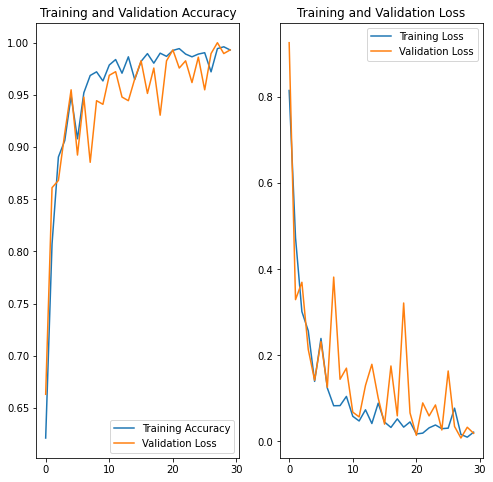

In [22]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Loss')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 34ms/step


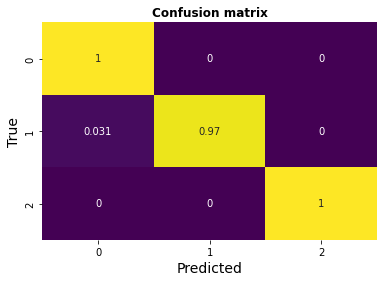

In [26]:

from sklearn.metrics import classification_report,confusion_matrix

y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in val_ds:  
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

# Confusion matrix
cm = confusion_matrix(correct_labels, predicted_labels, normalize='true')

sns.heatmap(cm, annot=True, cmap='viridis', cbar=None)

plt.title("Confusion matrix", fontweight='bold')
plt.ylabel("True", fontsize=14)
plt.xlabel("Predicted", fontsize=14)

plt.show()

In [28]:
print(classification_report(correct_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       102
           1       1.00      0.97      0.98        65
           2       1.00      1.00      1.00       121

    accuracy                           0.99       288
   macro avg       0.99      0.99      0.99       288
weighted avg       0.99      0.99      0.99       288



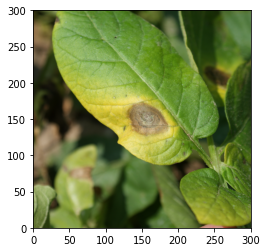

(256, 256, 3)
1/1 [==============================] - 0s 51ms/step
Potato___Early_blight 99.1


In [58]:
from PIL import Image
import numpy

img= Image.open("early.png").resize((256,256))
np_img = numpy.array(img)
np_img2=np_img

import numpy as np
from matplotlib import pyplot as plt
im = plt.imread("early.png")
fig, ax = plt.subplots()
im = ax.imshow(im, extent=[0, 300, 0, 300])
x = np.array(range(300))
ax.plot(x, x, ls='none', linewidth=2, color='red')
plt.show()

print(np_img.shape)

from keras.models import load_model

img_array = tf.keras.preprocessing.image.img_to_array(np_img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions[0])]
confidence = round(100 * (np.max(predictions[0])), 2)
print(predicted_class, confidence)

In [59]:
model.save("Best_CNN_march_30_epoch.h5")

In [ ]:
# misclassified: latina , latt, late3, late_blight